In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
import sys
import logging
import glob

tf.get_logger().setLevel(logging.ERROR)

sys.path.append('../src/')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


In [2]:
# import modules
from cnn.simulator import Simulator

from cnn.models import ConvNet
from cnn.losses import CustomLoss
from cnn.callbacks import SaveModelWeightsCallback

from cnn.metrics import CustomAUC
from cnn.metrics import CustomMREArea
from cnn.metrics import CustomMAELoc
from cnn.metrics import get_accuracy_metrics_at_thresholds

from cnn.preprocessing import LabelEncoder
from cnn.data_generators import DataGenerator

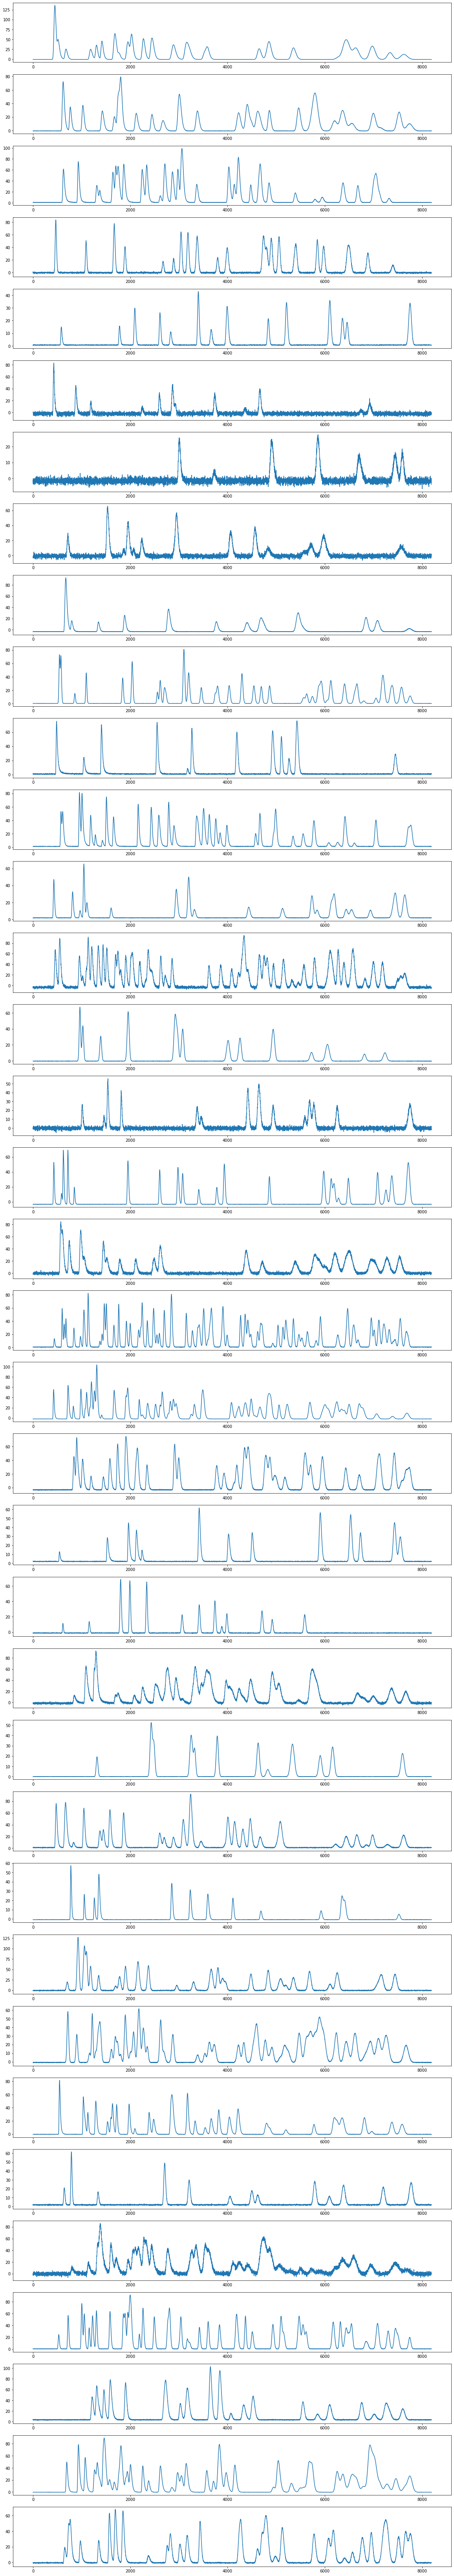

In [3]:
simulator_train = Simulator(LabelEncoder(256).remove_collision)

fig, axes = plt.subplots(36, 1, figsize=(20, 120))
for i in range(36):
    x = simulator_train._generate_example(i+100)['chromatogram']
    axes.reshape(-1)[i].plot(x)

In [ ]:

# Model training
NUM_TRAIN_EXAMPLES = int(1e6)
NUM_TEST_EXAMPLES = int(1e4)
BATCH_SIZE = 32
STEPS_PER_EPOCH = 1e5 // BATCH_SIZE
NUM_EPOCHS = 10

# Model optimizer
INITIAL_LEARNING_RATE = 1e-3
END_LEARNING_RATE = 1e-5
DECAY_STEPS = int(STEPS_PER_EPOCH / BATCH_SIZE * NUM_EPOCHS)

# Label encoder
NUM_CLASSES = 3
NUM_WINDOWS = 256
INPUT_SIZE = 8192


# Define loss function, optimizer and metrics
loss_fn = CustomLoss(NUM_CLASSES, 1.0, 1.0, 1.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=INITIAL_LEARNING_RATE, 
        decay_steps=DECAY_STEPS, 
        end_learning_rate=END_LEARNING_RATE
    )
)

metrics = [
    CustomMREArea(name='mre_area'),
    CustomMAELoc(name='mae_loc'),
    CustomAUC(name='prob_auc'),
] #+ get_accuracy_metrics_at_thresholds() # too much output (use if eval thresholds)

# Define data generators 
# Simulator uses method of label_encoder to deal with collisions
label_encoder = LabelEncoder(NUM_WINDOWS)
train_generator = DataGenerator(
    np.arange(0, NUM_TRAIN_EXAMPLES), 
    simulator=Simulator(label_encoder.remove_collision, resolution=INPUT_SIZE, 
                        white_noise_prob=1.0), 
    label_encoder=label_encoder,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = DataGenerator(
    np.arange(NUM_TRAIN_EXAMPLES, NUM_TRAIN_EXAMPLES + NUM_TEST_EXAMPLES), 
    simulator=Simulator(label_encoder.remove_collision, resolution=INPUT_SIZE, 
                        white_noise_prob=1.0), 
    label_encoder=label_encoder,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = ConvNet(
    filters=[64, 128, 128, 256, 256],
    kernel_sizes=[9, 9, 9, 9, 9],
    dropout=0.0,
    pool_type='max',
    pool_sizes=[2, 2, 2, 2, 2],
    conv_block_size=1,
    input_shape=(INPUT_SIZE, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES),
    residual=False
)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

# Weights will be saved each epoch to outputs/weights/
model.fit(
    train_generator, validation_data=test_generator,
    epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[SaveModelWeightsCallback()]
)

Epoch 1/10
 781/3125 [======>.......................] - ETA: 8:54 - loss: 0.9874 - mre_area: 0.2585 - mae_loc: 0.1031 - prob_auc: 0.9790